# Monte Carlo Methods: Coursework

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Efficiency of Monte Carlo sampling

The calculation will repeat the setup from lab 2, using a Lennard-Jones fluid, briefly repeated below. However, only a single set of physical parameters will be considered.

Use a Lennard-Jones potential inside a box size $[0,L]^3$ with a cut-off $r_c = L/2$, 

$$
\begin{equation}
U = \begin{cases} 4 \left[ \frac{1}{r^{12}} - \frac{1}{r^6} \right] & r < r_c \\ 0 & r > r_c. \end{cases}
\end{equation}
$$

Include tail corrections (that is, additional energy and pressure terms resulting from the particles outside the cutoff radius) as

$$
\begin{align}
  U^{\text{tail}} & = \frac{8 \pi \rho}{3} \left[ \frac{1}{3} \frac{1}{r_c^9} - \frac{1}{r_c^3} \right] \\
  p^{\text{tail}} & = \frac{16 \pi \rho^2}{3} \left[ \frac{2}{3} \frac{1}{r_c^9} - \frac{1}{r_c^3} \right].
\end{align}
$$

For each configuration we need to compute the pressure using

$$
\begin{equation}
  p = \frac{\rho}{\beta} + \frac{\text{Virial}}{3 V}
\end{equation}
$$

where

$$
\begin{equation}
  \text{Virial} = \sum_i \sum_{j > i} \vec{f}( \vec{r}_{ij} ) \cdot \vec{r}_{ij}
\end{equation}
$$

where, as usual, $\vec{r}_{ij}$ is the separation between the atoms, $\vec{r}_{ij} = \vec{r}_i - \vec{r}_j$, and the intermolecular force $\vec{f}$ is given by

$$
\begin{align}
  \vec{f}(\vec{r}_{ij}) &= - \nabla U \\
  & = \begin{cases} 24 \left[ 2 \frac{1}{r^{14}} - \frac{1}{r^8} \right] \vec{r}_{ij} & r < r_c \\ \vec{0} & r > r_c \end{cases}
\end{align}
$$

Note that in the reduced coordinates $\beta = T^{-1}$.

We will be using an $NTV$ approach, keeping the number of particles fixed ($N = 50$), the temperature fixed at $T=2$ and the volume fixed (indirectly, via the density $\rho = N / V = N L^{-3}$, using $\rho = 1/2$). Take $5,000$ steps.

## Tasks

Compare the efficiency of the standard Monte Carlo algorithm, as used in lab 2, with

1. an algorithm where each trial solution moves *all* particles by a random amount, and
2. an algorithm where each trial solution moves a single particle, but by an amount drawn from a Gaussian distribution instead of a uniform distribution.

In all three cases, run the algorithm three times, and plot the average of

$$
\begin{equation}
  \log \left| E - \min (E) + 1 \right|
\end{equation}
$$

against the number of iterations to show the relative efficiency of the algorithms. The size of the random move should be roughly tuned in each case so that the acceptance rate is $\sim 50\%$ - this will require different values of $\Delta$ in each case, and I would recommend starting with $\Delta \sim 0.1$ in the standard case and reducing by roughly a factor of $4$ for the Gaussian case, and roughly a further factor of $4$ when moving all particles.

In [2]:
%matplotlib inline
from __future__ import division
from multiprocessing import Process, Queue

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

from numba import jit

In [3]:
@jit
def pbcDiff(xArray, i, j, boxSize, cRatio):
    """
    Return the difference (vectorial) between two particles while taking into
    account possible interactions across the periodic boundaries. If the distance
    is higher than the cutoff radius a 0 is returned.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        xArray      Contains array of point coordinates
        boxSize     The size of the domain containing the points
        i           Index of the first particle
        j           Index of the seceond particle
        cRatio      The ratio of the boxSize to be used for cutoff distances
    Output:
        diff        The difference between two particles
    Internal variables:
        cases       Vector to check for interactions across the boundary
        index       Stores the index of the minimum distance between two particles
                    after a check is made for interactions over the boundary
    """
    N, dim = np.shape(xArray)
    diff = xArray[j, :] - xArray[i, :]
    # Contains three cases: closer as is, closer to the left, closer to the right
    cases = np.array([0, -boxSize, boxSize])
    for n in range(dim):
        # Add to the directions of interest to see if particles are closer over
        # the periodic boundaries
        index = np.argmin(np.abs(diff[n] + cases))
        diff[n] += cases[index]
    # Check if the cutoff condition is satisfied
    if np.linalg.norm(diff) < boxSize * float(cRatio):
        return diff
    else:
        return 0.0

In [4]:
@jit
def distances(xArray, boxSize, mDist=None, rd=None, cRatio=0.5):
    """
    Returns an N*N array of the distances between all particles in xArray.
    The returned array is upper triangular (U-T) to avoid redundancies and the
    0s in the U-T part show that the points are further apart than cutoff distance.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        xArray      Contains array of point coordinates
        boxSize     The size of the domain containing the points
        mDist       U-T matrix containing distances between all particles (opt)
        rd          Particle index where a change has occured (opt)
        cRatio      The ratio of the boxSize to be used for cutoff distances(opt)
    Outputs
        mDistOut    Compy of mDist with the changed distances
        my_bool     Returns a bool matrix to index ('True' values the changes 
                    made in the distance matrix and of all non-zero elements (opt)
    Local variables:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
    """
    N, dim = np.shape(xArray)   # Extraxt input matrix size
    # Check if the distance matrix has been computed before, i.e. if it is an input
    if mDist is not None:
        assert rd is not None,\
               "Please also input the modified particle index"
        my_bool = np.zeros(np.shape(mDist), dtype=bool)
        mDistOut = mDist.copy()
        for i in np.arange(rd):
            mDistOut[i, rd] = np.linalg.norm(
                pbcDiff(xArray, i, rd, boxSize, cRatio))
            if mDistOut[i, rd] > 0:
                my_bool[i, rd] = True
        for i in np.arange(rd, N):
            mDistOut[rd, i] = np.linalg.norm(
                pbcDiff(xArray, rd, i, boxSize, cRatio))
            if mDistOut[rd, i] > 0:
                my_bool[rd, i] = True
        return mDistOut, my_bool
    else:
        mDistOut = np.zeros([N, N])    # Initialise distance matrix
        # Compute distance from each particle to all others
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                mDistOut[i, j] = np.linalg.norm(
                    pbcDiff(xArray, i, j, boxSize, cRatio))
        return mDistOut

In [5]:
@jit
def rnd_move(xArray, boxSize, cRatio=0.1, rnd=0):
    """
    Returns the input array with one particle that has been randomly
    moved within a box wih periodic boundaries of the distance given by boxSize
    and centred at 0. The boxSize and cRatio are used to scale the movement.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        xArray      Contains array of point coordinates
        boxSize     The size of the domain containing the points
        cRatio      The ratio of the boxSize to be used for scaling of movement
    Outputs:
        yArray      A copy of the xArray to avoid overwriting memory
        rd          A random index to choose a point in xArray
    Internal variables:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
    """
    N, dim = np.shape(xArray)       # Store input matrix dimensions
    rd = int(np.random.rand()*N)    # Choose rand point and scale to N
    yArray = xArray.copy()
    # Randomly move point in all dimensions with scaling
    for i in np.arange(dim):
        if rnd==0:
            yArray[rd, i] += (np.random.rand() - 0.5) * cRatio * boxSize
        elif rnd==1:
            yArray[rd, i] += np.random.normal() * cRatio * boxSize
        else:
            raise ValueError("The only accepted values are 0 for uniform and 1 for gaussian/normal\
                             distributions. You have entered {}.".format(rnd))
        # Ensure that the moved point lies within the given box size
        if yArray[rd, i] > boxSize/2.:
            yArray[rd, i] -= boxSize
        if yArray[rd, i] < -boxSize/2.:
            yArray[rd, i] += boxSize
    return yArray, rd

In [6]:
@jit
def rnd_move_all(xArray, boxSize, cRatio=0.1):
    """
    Returns the input array with all particles randomly moved within a box 
    wih periodic boundaries of the distance given by boxSize and centred at
    0. The boxSize and cRatio are used to scale the movement.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        xArray      Contains array of point coordinates
        boxSize     The size of the domain containing the points
        cRatio      The ratio of the boxSize to be used for scaling of movement
    Outputs:
        yArray      A copy of the xArray to avoid overwriting memory
    Internal variables:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
    """
    N, dim = np.shape(xArray)       # Store input matrix dimensions
    yArray = xArray.copy()
    # Randomly move point in all dimensions with scaling
    yArray += (np.random.rand(N,dim) - 0.5) * cRatio * boxSize
    # Keep particles inside the box
    yArray[yArray > boxSize/2.0] += -boxSize
    yArray[yArray < -boxSize/2.0] += boxSize
    return yArray

In [7]:
@jit
def pressure(xArray, mDist, boxSize, cRatio):
    """
    Returns the pressure given the particle positions and the distances using
    the Lennard-Jones approximation.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        xArray      Contains array of point coordinates
        mDist       U-T matrix containing distances between all particles
    Outputs:
        p           Pressure
    Internal variables:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
        diff        Difference between two points (vector)
        inner       Inner product    
    """
    N, dim = np.shape(xArray)
    p = 0.0
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            # Store distance in a variable to avoid accessing it repeatedly
            r = mDist[i, j]
            # Compute pressure only if distance is non-zero, i.e. the particles
            # are closer than the cutoff radius
            if r > 0:
                diff = pbcDiff(xArray, i, j, boxSize, cRatio)
                inner = np.dot(diff, diff)
                p += 8.0 * inner * (2 * r**(-14) - r**(-8))
    return p

In [8]:
@jit
def mc_LJ(N, dim, a, T, no_smples, cRatio, delta, dist=0, q=None):
    """
    Return the potential final positions, energy, pressure and the number of
    accepted trials (throught the length of the enery vector - 1) for a set of 
    particles using Lennard-Jones interaction. The distribution from which the
    particle movement is extracted can also be specified.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
        a           Density magnitude
        T           Temperature
        no_smples   Number of random particle movements to be tried
        cRatio      A ratio of the box side length for radius cutoff
        dist        Specify the function that gives the random distribution
        q           A queue to be used to store the results when run in parallel(opt)
    Outputs:
        pos         Final position of particles for the relaxed system
        U           Vector of energies for all accepted cases
        p           Pressure of the final configuration (relaxed system)
    Internal variables:
        rho         Density
        boxSize     Length of one side of the periodic cube
        rc          Cutoff distance
        utail       Add an approximation for the contribution of particles further
                    than rc to the Energy
        ptail       Same as above but for Pressure
        temp_pos    Store positions for the trial move
        temp_mDist  Store distances for the trial move
        mBool       A bool array to store the indices where the current distance
                    matrix has been changed and where it is non-zero
        mBool_oCfg  A bool array to store the indeces of the previously accepted
                    distance matrix so that it can be easily subtracted from the
                    previously accepted energy level
        u           Variable to store the energy level due to the current move
        pv          Variable to store the virial part of the pressure / Volume
        
    """
    rho = float(a)/10.0           # Density
    boxSize = (N/rho)**(1/3.)       # Box side length
    rc = boxSize * float(cRatio)    # Compute the cutoff radius
    # Create a random set of N particles and compute the distances between them
    pos = (np.random.rand(N, dim) - .5) * boxSize
    mDist = distances(xArray=pos, boxSize=boxSize)
    # Compute tail values for energy (utail) and pressure (ptail)
    utail = 8 * constants.pi * rho/3.0 * (1/3. * rc**(-9) - rc**(-3))
    ptail = 16 * constants.pi * (rho**2)/3.0 * (2/3. * rc**(-9) - rc**(-3))
    # Initialise an array to store the energies with the value given by current
    # distances
    U = np.array([np.sum(4 * (mDist[mDist>0]**(-12) - mDist[mDist>0]**(-6))) + utail])
    E = np.zeros((no_smples,1))
    E[0] = U[0]
    for i in np.arange(no_smples):
        # Move particle and store new positions, then compute distances and a 
        # bool matrix to determine where replacements have occured
        temp_pos, rd = rnd_move(pos, boxSize, rnd=dist, cRatio=delta)
        temp_mDist, mBool = distances(temp_pos, boxSize, mDist, rd)
        # Create a bool matrix for the old non-zero indeces of the accepted mDist
        mBool_oCfg = np.zeros(np.shape(mBool), dtype = bool)
        mBool_oCfg[:rd, rd] = True
        mBool_oCfg[rd, rd:] = True
        mBool_oCfg = (mDist > 0) & mBool
        # Compute energy by subtracting from the last accepted value the
        # contribution from the prev distances and adding the new
        u = U[-1] - np.sum(4 * (mDist[mBool_oCfg]**(-12) - mDist[mBool_oCfg]**(-6))) +\
                np.sum(4 * (temp_mDist[mBool]**(-12) - temp_mDist[mBool]**(-6)))
        # Accept move either if the energy is lower or if the gaussian is larger
        # than a random value. Update all components
        if (u < U[-1]) or (np.exp((U[-1]-u)/float(T)) > np.random.rand()):
            U = np.append(U, u)
            mDist = temp_mDist
            pos = temp_pos
        E[i] = u
    U = U.reshape(len(U),1)
    pv = pressure(pos, mDist, boxSize, cRatio)/(float(N) / rho)
    p = rho*T + pv + ptail
    # Enables the use of a queue for parallel processing
    if q is not None:
        q.put((a, pos, U, E, p))
    return pos, U, E, p

In [9]:
@jit
def mc_LJ_all(N, dim, a, T, no_smples, cRatio, delta, q=None):
    """
    Return the potential final positions, energy, pressure and the number of
    accepted trials (throught the length of the enery vector - 1) for a set of 
    particles using Lennard-Jones interaction, where all particles are randomly
    moved.
            10/10/2015  K. Drakopoulos (kd1e15@soton.ac.uk)
    Inputs:
        N           Number of points, i.e. rows
        dim         Number of dimensions, i.e columns
        a           Density magnitude
        T           Temperature
        no_smples   Number of random particle movements to be tried
        cRatio      A ratio of the box side length for radius cutoff
        q           A queue to be used to store the results when run in parallel(opt)
    Outputs:
        pos         Final position of particles for the relaxed system
        U           Vector of energies for all accepted cases
        p           Pressure of the final configuration (relaxed system)
    Internal variables:
        rho         Density
        boxSize     Length of one side of the periodic cube
        rc          Cutoff distance
        utail       Add an approximation for the contribution of particles further
                    than rc to the Energy
        ptail       Same as above but for Pressure
        temp_pos    Store positions for the trial move
        temp_mDist  Store distances for the trial move
        mBool       A bool array to store the indices where the current distance
                    matrix has been changed and where it is non-zero
        mBool_oCfg  A bool array to store the indeces of the previously accepted
                    distance matrix so that it can be easily subtracted from the
                    previously accepted energy level
        u           Variable to store the energy level due to the current move
        pv          Variable to store the virial part of the pressure / Volume
        
    """
    rho = float(a)/10.0             # Density
    boxSize = (N/rho)**(1/3.)       # Box side length
    rc = boxSize * float(cRatio)    # Compute the cutoff radius
    # Create a random set of N particles and compute the distances between them
    pos = (np.random.rand(N, dim) - .5) * boxSize
    mDist = distances(xArray=pos, boxSize=boxSize)
    # Compute tail values for energy (utail) and pressure (ptail)
    utail = 8 * constants.pi * rho/3.0 * (1/3. * rc**(-9) - rc**(-3))
    ptail = 16 * constants.pi * (rho**2)/3.0 * (2/3. * rc**(-9) - rc**(-3))
    # Initialise an array to store the energies with the value given by current
    # distances
    U = np.array([np.sum(4 * (mDist[mDist>0]**(-12) - mDist[mDist>0]**(-6))) + utail])
    E = np.zeros((no_smples,1))
    E[0] = U[0]
    for i in np.arange(no_smples):
        # Move particle and store new positions, then compute distances
        temp_pos = rnd_move_all(pos, boxSize, cRatio=delta)
        temp_mDist = distances(xArray=temp_pos, boxSize=boxSize)
        # Compute energy
        u = np.sum(4 * (temp_mDist[temp_mDist>0]**(-12) - temp_mDist[temp_mDist>0]**(-6))) + utail
        # Accept move either if the energy is lower or if the gaussian is larger
        # than a random value. Update all components
        if (u < U[-1]) or (np.exp((U[-1]-u)/float(T)) > np.random.rand()):
            U = np.append(U, u)
            mDist = temp_mDist
            pos = temp_pos
        E[i] = u
    U = U.reshape(len(U),1)
    pv = pressure(pos, mDist, boxSize, cRatio)/(float(N) / rho)
    p = rho*T + pv + ptail
    # Enables the use of a queue for parallel processing
    if q is not None:
        q.put((a, pos, U, E, p, acc))
    return pos, U, E, p

In [10]:
def perf(mArray):
    """Return the logarithmic fluctuation of energy"""
    return np.log(np.abs(mArray - np.min(mArray) + 1))

In [11]:
"""Initialise the three cases: Uniform (A), Gaussian (B), All Particles (C)"""
A = {}
B = {}
C = {}
for i in range(3):
    A["run{}".format(i)] = mc_LJ(N=50, dim=3, a=5.0, T=2.0, no_smples=5000, cRatio=0.5, dist=0, delta=0.1)
    B["run{}".format(i)] = mc_LJ(N=50, dim=3, a=5.0, T=2.0, no_smples=5000, cRatio=0.5, dist=1, delta=0.024)
    C["run{}".format(i)] = mc_LJ_all(N=50, dim=3, a=5.0, T=2.0, no_smples=5000, cRatio=0.5, delta=0.006)

In [12]:
"""Compute the averages necessary to create the first figure below"""
# Create vectors to append the energies
enA = np.zeros((5000,1))
enB = np.zeros((5000,1))
enC = np.zeros((5000,1))
for i in range(3):
    enA = np.append(enA, A["run{}".format(i)][2], axis=1)
    enB = np.append(enB, B["run{}".format(i)][2], axis=1)
    enC = np.append(enC, C["run{}".format(i)][2], axis=1)
# Delete the first column that was created previously
enA = np.delete(enA, 0, 1)
enB = np.delete(enB, 0, 1)
enC = np.delete(enC, 0, 1)
# Compute the averages
avgA = np.mean(enA, axis=1)
avgB = np.mean(enB, axis=1)
avgC = np.mean(enC, axis=1)

In [13]:
"""Compute the averages necessary to create the second figure below"""
# Find the shortest vectors for the three cases
ina = np.min([len(A["run0"][1]), len(A["run1"][1]), len(A["run2"][1])])
inb = np.min([len(B["run0"][1]), len(B["run1"][1]), len(B["run2"][1])])
inc = np.min([len(C["run0"][1]), len(C["run1"][1]), len(C["run2"][1])])
# Append all vectors and cut them off to be of the same length of the shortest vector
UA = np.append(A["run0"][1][-ina:], np.append(A["run1"][1][-ina:], A["run2"][1][-ina:], axis=1), axis=1)
UB = np.append(B["run0"][1][-inb:], np.append(B["run1"][1][-inb:], B["run2"][1][-inb:], axis=1), axis=1)
UC = np.append(C["run0"][1][-inc:], np.append(C["run1"][1][-inc:], C["run2"][1][-inc:], axis=1), axis=1)
# Compute the averages
avgUA = np.mean(UA, axis=1)
avgUB = np.mean(UB, axis=1)
avgUC = np.mean(UC, axis=1)

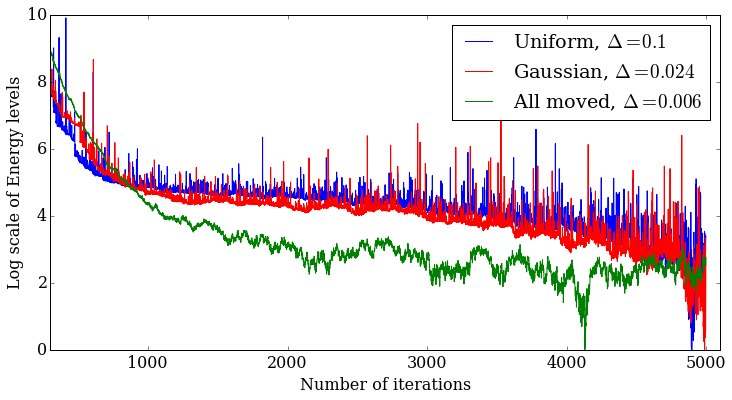

In [21]:
"""Create the first figure"""
fig = plt.figure()
ax = fig.add_subplot(111)
rng = 300
lim = 5000
ax.plot(np.arange(rng, lim), perf(avgA[rng:]), 'b', label = r"Uniform, $\Delta = 0.1$")
ax.plot(np.arange(rng, lim), perf(avgB[rng:]), 'r', label = r"Gaussian, $\Delta = 0.024$")
ax.plot(np.arange(rng, lim), perf(avgC[rng:]), 'g', label = r"All moved, $\Delta = 0.006$")
ax.set_xlim(rng, 5100)
ax.set_xlabel(r"Number of iterations")
ax.set_ylabel(r"Log scale of Energy levels")
ax.legend()

The Figure above shows that the fastest convergence to the lower values is achieved by using a uniform distribution (see slopes at the left side of the graph). Extracting the amount of random movement from a gaussian distribution is slower due to the smaller amount by which the particles are moved, since most values lie around 0. Different results will be obtained if a larger standard deviation is used and the method will converge faster. Moving all the particles at once produces the slowest rate of convergence since all of them have to be moved by extremely small amounts ($\Delta$) so that the method converges. When all particles are moved at once, the Energy seems to converge to much lower values than in the previous two cases, even though it is not very clear since the energy still tends to fluctuate by large amounts due to the Metropolis Criterion. The minimum values that the three methods achieve are $\sim -150$ and $\sim -250$, for the *All particles* and the *One at a time* cases respectively.

Another area of interest is towards the end of the *Uniform* and *Gaussian* distributions. The larger movements achieved in the *Uniform* case makes the energy fluctuate to a higher degree due to the Metropolis Criterion. Of notice is also the much higher occurence of very high "spikes" in the *Gaussian* case due to the extraction of values from the edges of that distribution.

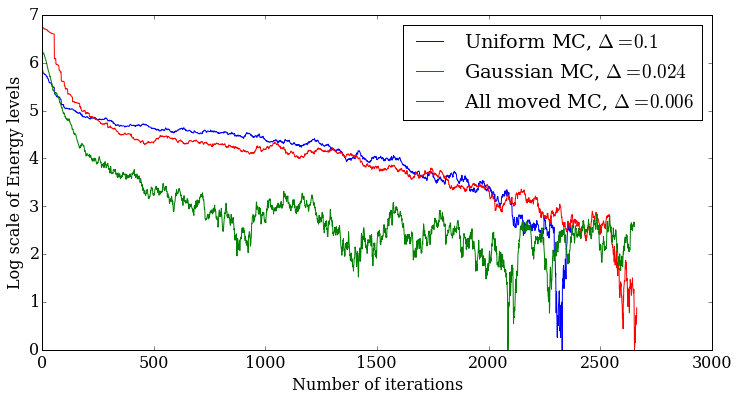

In [15]:
"""Create the second figure"""
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(perf(avgUA[200:]), 'b', label = r"Uniform MC, $\Delta = 0.1$")
ax.plot(perf(avgUB[200:]), 'r', label = r"Gaussian MC, $\Delta = 0.024$")
ax.plot(perf(avgUC[200:]), 'g', label = r"All moved MC, $\Delta = 0.006$")
ax.set_xlabel(r"Number of iterations")
ax.set_ylabel(r"Log scale of Energy levels")
ax.legend()

The Figure above shows how the accepted energy levels fluctuate for the three cases. Here it is more visible what a large difference the metropolis criterion plays in the three methods. In the *Uniform* and *Gaussian* cases the accepted energies reach a low energy level which is then more difficult to overcome since movements that would greatly increase the energy of the system are much less probable to occur and get accepted by the metropolis criterion. When all particles are moved at once the criterion plays a larger role due to the high volume of high energy system configurations.

In [16]:
for i in range(3):
    print "Case A: the acceptance percentage for run {} is {}%".format(i, len(A["run{}".format(i)][1] - 1)/50.0)
for i in range(3):
    print "Case B: the acceptance percentage for run {} is {}%".format(i, len(B["run{}".format(i)][1] - 1)/50.0)
for i in range(3):
    print "Case C: the acceptance percentage for run {} is {}%".format(i, len(C["run{}".format(i)][1] - 1)/50.0)

Case A: the acceptance percentage for run 0 is 52.3%
Case A: the acceptance percentage for run 1 is 52.08%
Case A: the acceptance percentage for run 2 is 51.42%
Case B: the acceptance percentage for run 0 is 57.3%
Case B: the acceptance percentage for run 1 is 59.34%
Case B: the acceptance percentage for run 2 is 58.34%
Case C: the acceptance percentage for run 0 is 57.58%
Case C: the acceptance percentage for run 1 is 57.1%
Case C: the acceptance percentage for run 2 is 57.34%
